In [25]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import cv2
import matplotlib.pyplot as plt
import os
import time
from model.yolo_model import YOLO
import numpy as np

In [37]:
url = 'http://192.168.0.105/'  # Replace with the URL of your website

# Fetch the HTML content of the page
response = requests.get(url)
html_content = response.text

# Parse the HTML content
soup = BeautifulSoup(html_content, 'html.parser')

# Find the <img> tag with the ID 'photo'
img_tag = soup.find('img', {'id': 'photo'})

# Extract the 'src' attribute (image URL)
img_url = img_tag['src'] if img_tag else None

if img_url:
    # Convert the relative URL to an absolute URL
    img_url = urljoin(url, img_url)
    
    print(f"Image URL: {img_url}")
    
    # Create the 'images' folder if it doesn't exist
    if not os.path.exists('images'):
        os.makedirs('images')
    
    # Download and save the image
    img_response = requests.get(img_url)
    if img_response.status_code == 200:
        # Save the image inside the 'images' folder
        img_path = os.path.join('images', 'saved-photo.jpg')
        with open(img_path, 'wb') as f:
            f.write(img_response.content)
        print(f"Image saved as '{img_path}'")
    else:
        print(f"Failed to download image. Status code: {img_response.status_code}")
else:
    print("Image not found.")

Image URL: http://192.168.0.105/saved-photo
Image saved as 'images\saved-photo.jpg'


In [38]:

img = cv2.imread('images/saved-photo.jpg')

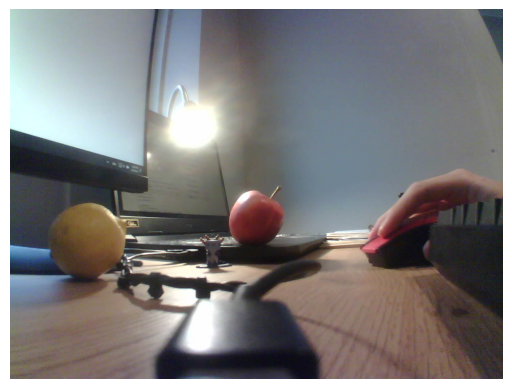

In [39]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Plot the image using matplotlib
plt.imshow(img_rgb)
plt.axis('off')  # Hide axes
plt.show()

In [40]:
def process_image(img):
    """Resize, reduce and expand image.

    # Argument:
        img: original image.

    # Returns
        image: ndarray(64, 64, 3), processed image.
    """
    image = cv2.resize(img, (416, 416),
                       interpolation=cv2.INTER_CUBIC)
    image = np.array(image, dtype='float32')
    image /= 255.
    image = np.expand_dims(image, axis=0)

    return image

In [41]:
def get_classes(file):
    """Get classes name.

    # Argument:
        file: classes name for database.

    # Returns
        class_names: List, classes name.

    """
    with open(file) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]

    return class_names

In [42]:
def draw(image, boxes, scores, classes, all_classes):
    """Draw the boxes on the image.

    # Argument:
        image: original image.
        boxes: ndarray, boxes of objects.
        classes: ndarray, classes of objects.
        scores: ndarray, scores of objects.
        all_classes: all classes name.
    """
    for box, score, cl in zip(boxes, scores, classes):
        x, y, w, h = box

        top = max(0, np.floor(x + 0.5).astype(int))
        left = max(0, np.floor(y + 0.5).astype(int))
        right = min(image.shape[1], np.floor(x + w + 0.5).astype(int))
        bottom = min(image.shape[0], np.floor(y + h + 0.5).astype(int))

        cv2.rectangle(image, (top, left), (right, bottom), (255, 0, 0), 2)
        cv2.putText(image, '{0} {1:.2f}'.format(all_classes[cl], score),
                    (top, left - 6),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (0, 0, 255), 1,
                    cv2.LINE_AA)

        print('class: {0}, score: {1:.2f}'.format(all_classes[cl], score))
        print('box coordinate x,y,w,h: {0}'.format(box))

    print()

In [43]:
def detect_image(image, yolo, all_classes):
    """Use yolo v3 to detect images.

    # Argument:
        image: original image.
        yolo: YOLO, yolo model.
        all_classes: all classes name.

    # Returns:
        image: processed image.
    """
    pimage = process_image(image)

    start = time.time()
    boxes, classes, scores = yolo.predict(pimage, image.shape)
    end = time.time()

    print('time: {0:.2f}s'.format(end - start))

    if boxes is not None:
        draw(image, boxes, scores, classes, all_classes)

    return image

In [44]:
def detect_video(video, yolo, all_classes):
    """Use yolo v3 to detect video.

    # Argument:
        video: video file.
        yolo: YOLO, yolo model.
        all_classes: all classes name.
    """
    video_path = os.path.join("videos", "test", video)
    camera = cv2.VideoCapture(video_path)
    cv2.namedWindow("detection", cv2.WINDOW_AUTOSIZE)

    # Prepare for saving the detected video
    sz = (int(camera.get(cv2.CAP_PROP_FRAME_WIDTH)),
        int(camera.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    fourcc = cv2.VideoWriter_fourcc(*'mpeg')

    
    vout = cv2.VideoWriter()
    vout.open(os.path.join("videos", "res", video), fourcc, 20, sz, True)

    while True:
        res, frame = camera.read()

        if not res:
            break

        image = detect_image(frame, yolo, all_classes)
        cv2.imshow("detection", image)

        # Save the video frame by frame
        vout.write(image)

        if cv2.waitKey(110) & 0xff == 27:
                break

    vout.release()
    camera.release()
    

In [45]:
yolo = YOLO(0.6, 0.5)
file = 'data/coco_classes.txt'
all_classes = get_classes(file)

In [48]:
f = 'saved-photo.jpg'
path = 'images/'+f
image = cv2.imread(path)
image = detect_image(image, yolo, all_classes)
cv2.imwrite('images/res/' + f, image)

1/1 [==============================] - 0s 476ms/step
time: 0.55s


True

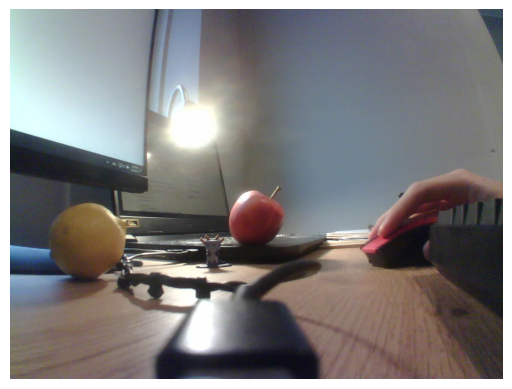

In [49]:
img = cv2.imread('images/res/saved-photo.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Plot the image using matplotlib
plt.imshow(img_rgb)
plt.axis('off')  # Hide axes
plt.show()